In [1]:
!pip -q install pyddm

Indvidual assignment: DDM for analysing the effect of prior expextation on the reaction time and accuracy

In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyddm
import seaborn as sns
from scipy.stats import ttest_rel,  sem
from scipy.stats import t
from pyddm import Model, DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, Fittable, LossRobustLikelihood, Sample


In [3]:
# Step one load the data
data= pd.read_csv("dataset-7.tsv", sep='\t')
data['correct'] = (data['S'] == data['R']).astype(int)
data


,subjects,S,flankers,R,rt,correct
0,1,right,incongruent,right,0.640099,1
1,1,right,incongruent,right,2.532234,1
2,1,left,congruent,left,0.510970,1
3,1,right,congruent,right,0.376156,1
4,1,left,incongruent,left,0.557056,1
...,...,...,...,...,...,...
5515,12,left,congruent,left,0.265228,1
5516,12,right,incongruent,right,0.396152,1
5517,12,left,congruent,left,0.389217,1
5518,12,left,congruent,right,0.165431,0


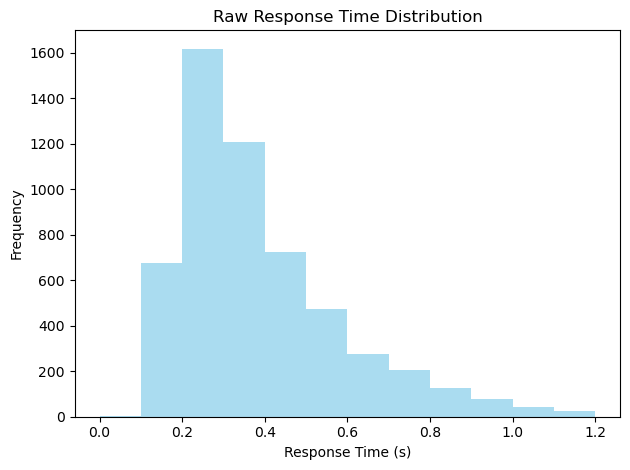

In [35]:
# Visualize raw response times
plt.hist(data['rt'], bins=np.arange(0, max(data['rt']), 0.1), alpha=0.7, color='skyblue')
plt.title("Raw Response Time Distribution")
plt.xlabel('Response Time (s)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


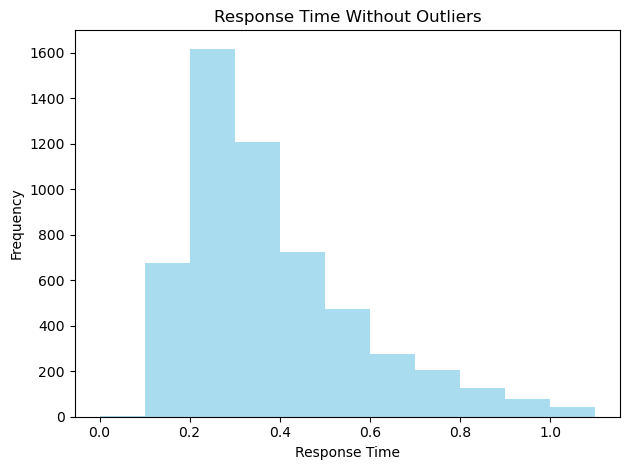

In [36]:
# Remove invalid response times (e.g., rt <= 0)
data = data[data['rt'] > 0]

# Remove outliers by filtering response times within the 10th and 90th percentiles
Q1 = data['rt'].quantile(0.1)
Q3 = data['rt'].quantile(0.9)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier removal
lower_bound = Q1 - IQR
upper_bound = Q3 + IQR

# Filter the dataset to include only response times within the defined bounds
data = data[(data['rt'] >= lower_bound) & (data['rt'] <= upper_bound)]

# Re-add the 'correct' column to the filtered data
data['correct'] = (data['S'] == data['R']).astype(int)

# Visualize the cleaned response time distribution
plt.hist(data['rt'], bins=np.arange(0, max(data['rt']), 0.1), alpha=0.7, color='skyblue')
plt.title("Response Time Without Outliers")
plt.xlabel('Response Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

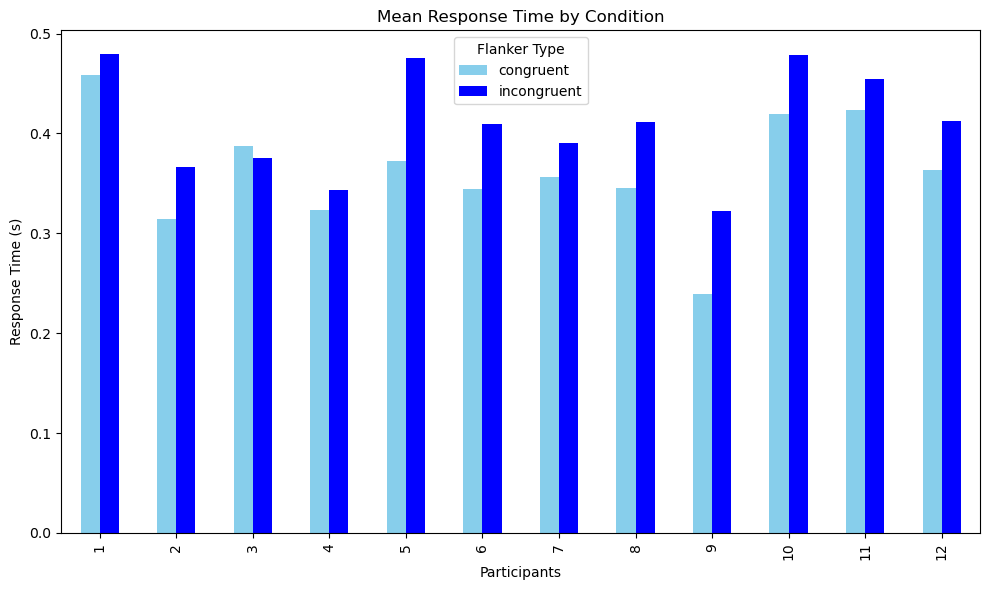

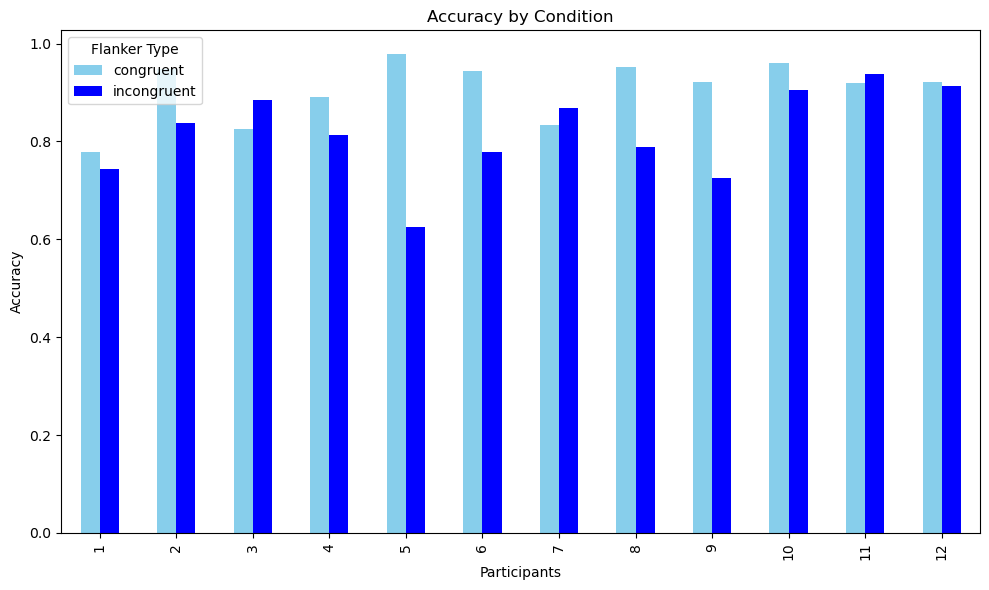

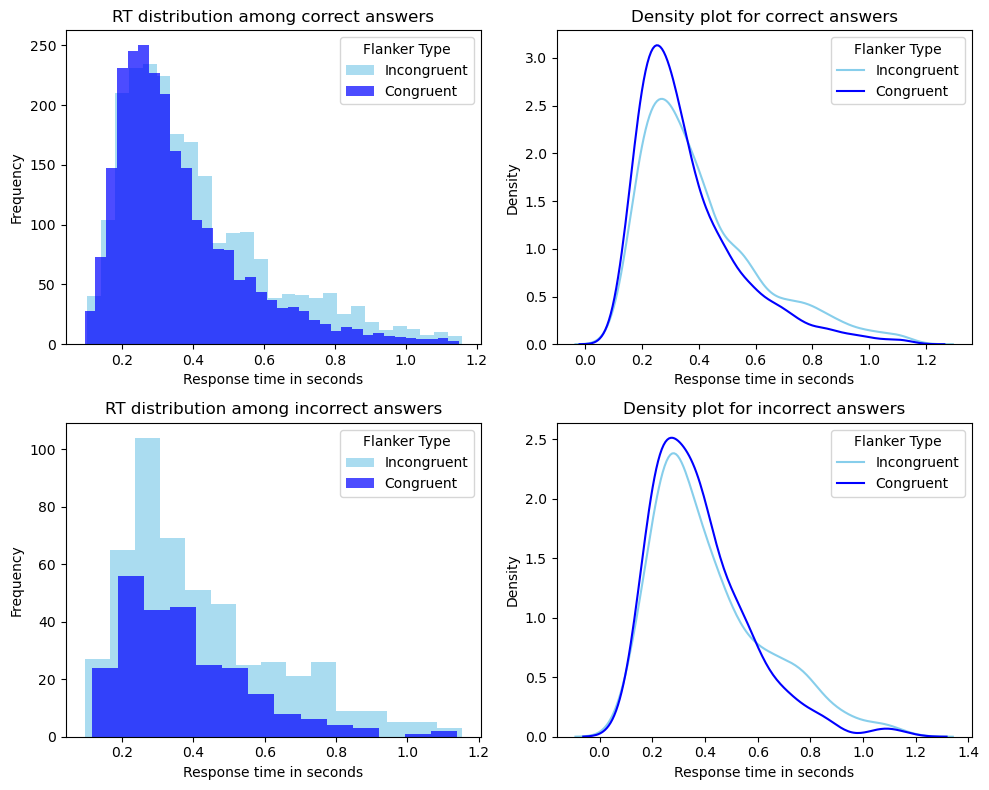

In [38]:
# Step 2: Exploratory Analysis
# Recalculate grouped data for mean response time and accuracy
mean_rt = data.groupby(['subjects', 'flankers'])['rt'].mean().unstack()
accuracy = data.groupby(['subjects', 'flankers'])['correct'].mean().unstack()

# Extract unique experimental conditions based on the 'flankers' column
conditions = data['flankers'].unique()

# Calculate the mean response time and accuracy for each condition and participant
mean_rt = data.groupby(['subjects', 'flankers'])['rt'].mean().unstack()
accuracy = data.groupby(['subjects', 'flankers'])['correct'].mean().unstack()

# Visualize mean response times by condition
mean_rt.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'blue'])
plt.title("Mean Response Time by Condition")
plt.xlabel("Participants")
plt.ylabel("Response Time (s)")
plt.legend(title="Flanker Type")
plt.tight_layout()
plt.show()

# Visualize accuracy by condition
accuracy.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'blue'])
plt.title("Accuracy by Condition")
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.legend(title="Flanker Type")
plt.tight_layout()
plt.show()


# Visualize response time distributions for correct and incorrect answers by condition
correct_incongruent = data[(data['flankers'] == 'incongruent') & (data['correct'] == 1)]['rt']
correct_congruent = data[(data['flankers'] == 'congruent') & (data['correct'] == 1)]['rt']
incorrect_incongruent = data[(data['flankers'] == 'incongruent') & (data['correct'] == 0)]['rt']
incorrect_congruent = data[(data['flankers'] == 'congruent') & (data['correct'] == 0)]['rt']

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Top-left: Histogram for correct answers
ax[0, 0].hist(correct_incongruent, bins='auto', color='skyblue', alpha=0.7, label='Incongruent')
ax[0, 0].hist(correct_congruent, bins='auto', color='blue', alpha=0.7, label='Congruent')
ax[0, 0].set_xlabel('Response time in seconds')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title("RT distribution among correct answers")
ax[0, 0].legend(title="Flanker Type")

# Top-right: Density plot for correct answers
sns.kdeplot(correct_incongruent, color='skyblue', ax=ax[0, 1], label='Incongruent')
sns.kdeplot(correct_congruent, color='blue', ax=ax[0, 1], label='Congruent')
ax[0, 1].set_xlabel('Response time in seconds')
ax[0, 1].set_ylabel('Density')
ax[0, 1].set_title("Density plot for correct answers")
ax[0, 1].legend(title="Flanker Type")

# Bottom-left: Histogram for incorrect answers
ax[1, 0].hist(incorrect_incongruent, bins='auto', color='skyblue', alpha=0.7, label='Incongruent')
ax[1, 0].hist(incorrect_congruent, bins='auto', color='blue', alpha=0.7, label='Congruent')
ax[1, 0].set_xlabel('Response time in seconds')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title("RT distribution among incorrect answers")
ax[1, 0].legend(title="Flanker Type")

# Bottom-right: Density plot for incorrect answers
sns.kdeplot(incorrect_incongruent, color='skyblue', ax=ax[1, 1], label='Incongruent')
sns.kdeplot(incorrect_congruent, color='blue', ax=ax[1, 1], label='Congruent')
ax[1, 1].set_xlabel('Response time in seconds')
ax[1, 1].set_ylabel('Density')
ax[1, 1].set_title("Density plot for incorrect answers")
ax[1, 1].legend(title="Flanker Type")

plt.tight_layout()
plt.show()

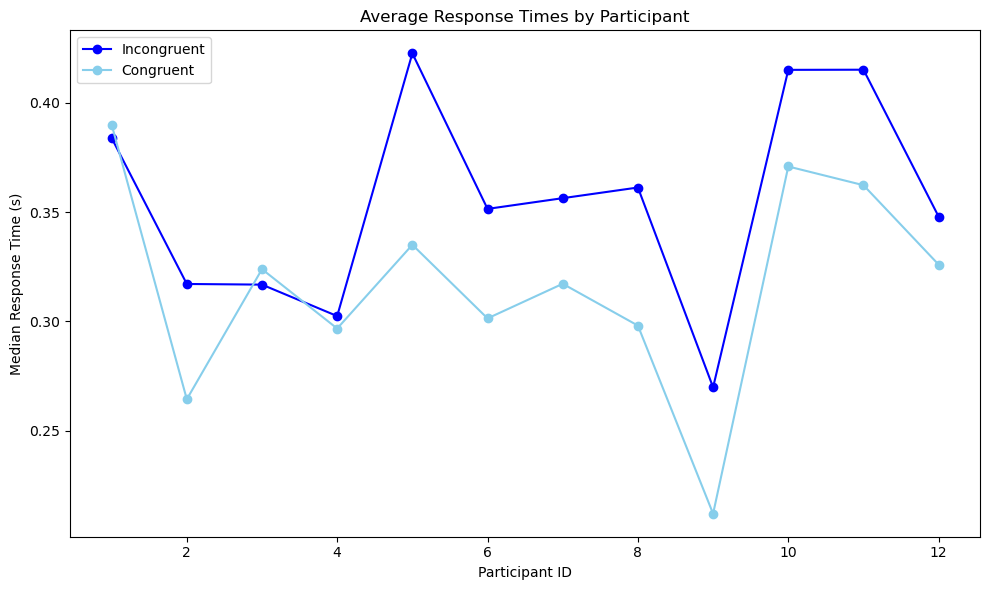

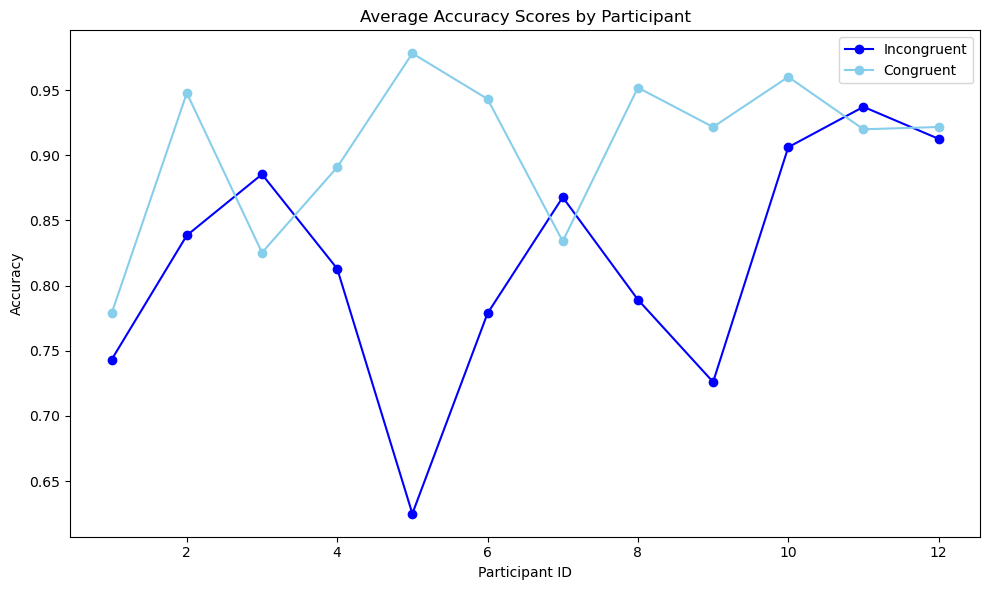

In [ ]:
# Participant-Level Averages and Scores
n_participants = len(data['subjects'].unique())
avg_rt1 = []
avg_rt2 = []
avg_score1 = []
avg_score2 = []

# Loop through each participant
for idx in range(1, n_participants + 1):
    # Calculate the average response time for both conditions ('incongruent' and 'congruent')
    rt_incongruent = np.median(data[(data['flankers'] == 'incongruent') & (data['subjects'] == idx)]['rt'])
    avg_rt1.append(rt_incongruent)
    rt_congruent = np.median(data[(data['flankers'] == 'congruent') & (data['subjects'] == idx)]['rt'])
    avg_rt2.append(rt_congruent)

    # Calculate the accuracy score for both conditions ('incongruent' and 'congruent')
    responses_incongruent = data[(data['flankers'] == 'incongruent') & (data['subjects'] == idx)]
    score_incongruent = (responses_incongruent['R'] == responses_incongruent['S']).mean() 
    avg_score1.append(score_incongruent)

    responses_congruent = data[(data['flankers'] == 'congruent') & (data['subjects'] == idx)]
    score_congruent = (responses_congruent['R'] == responses_congruent['S']).mean() 
    avg_score2.append(score_congruent)

# Visualize average response times by participant
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_participants + 1), avg_rt1, label='Incongruent', color='blue', marker='o')
plt.plot(range(1, n_participants + 1), avg_rt2, label='Congruent', color='skyblue', marker='o')
plt.title("Average Response Times by Participant")
plt.xlabel("Participant ID")
plt.ylabel("Median Response Time (s)")
plt.legend()
plt.tight_layout()
plt.show()

# Visualize average accuracy scores by participant
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_participants + 1), avg_score1, label='Incongruent', color='blue', marker='o')
plt.plot(range(1, n_participants + 1), avg_score2, label='Congruent', color='skyblue',  marker='o')
plt.title("Average Accuracy Scores by Participant")
plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


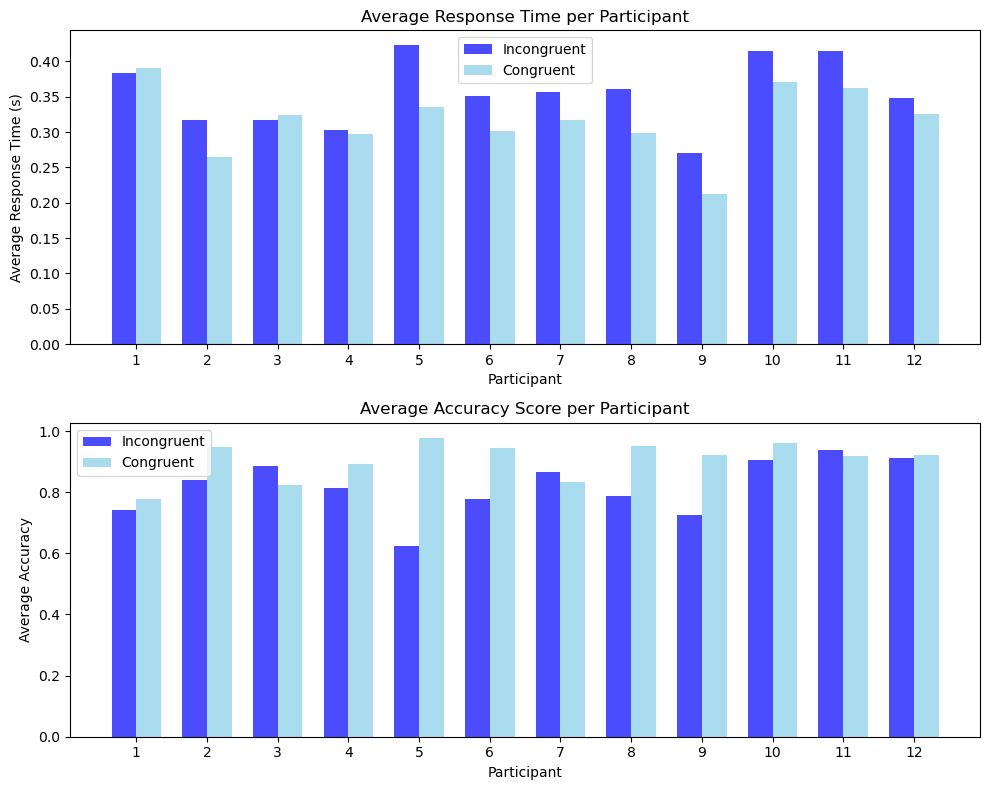

In [ ]:
# Step 6: Participant-Level Analysis
n_participants = len(data['subjects'].unique())
avg_rt1 = []
avg_rt2 = []
avg_score1 = []
avg_score2 = []

# Loop through each participant
for idx in range(1, n_participants + 1):
    # Calculate the average response time for both conditions ('incongruent' and 'congruent')
    rt_incongruent = np.median(data[(data['flankers'] == 'incongruent') & (data['subjects'] == idx)]['rt'])
    avg_rt1.append(rt_incongruent)
    rt_congruent = np.median(data[(data['flankers'] == 'congruent') & (data['subjects'] == idx)]['rt'])
    avg_rt2.append(rt_congruent)

    # Calculate the accuracy score for both conditions ('incongruent' and 'congruent')
    responses_incongruent = data[(data['flankers'] == 'incongruent') & (data['subjects'] == idx)]
    score_incongruent = (responses_incongruent['R'] == responses_incongruent['S']).mean()  
    avg_score1.append(score_incongruent)

    responses_congruent = data[(data['flankers'] == 'congruent') & (data['subjects'] == idx)]
    score_congruent = (responses_congruent['R'] == responses_congruent['S']).mean() 
    avg_score2.append(score_congruent)

# Visualize average response times by participant
participants = np.arange(1, n_participants + 1)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column of plots

width = 0.35  # width of the bars

# Plot average response time (RT) for each condition
axs[0].bar(participants - width/2, avg_rt1, width, color = 'blue', label='Incongruent', alpha=0.7)
axs[0].bar(participants + width/2, avg_rt2, width, color = 'skyblue', label='Congruent', alpha=0.7)
axs[0].set_title('Average Response Time per Participant')
axs[0].set_xlabel('Participant')
axs[0].set_ylabel('Average Response Time (s)')
axs[0].set_xticks(participants)
axs[0].legend()

# Plot average accuracy scores for each condition
axs[1].bar(participants - width/2, avg_score1, width, color = 'blue', label='Incongruent', alpha=0.7)
axs[1].bar(participants + width/2, avg_score2, width, color = 'skyblue', label='Congruent', alpha=0.7)
axs[1].set_title('Average Accuracy Score per Participant')
axs[1].set_xlabel('Participant')
axs[1].set_ylabel('Average Accuracy')
axs[1].set_xticks(participants)
axs[1].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
def compute_CI(values):
    mean_val = np.mean(values)
    std_error = np.std(values, ddof=1) / np.sqrt(len(values))
    confidence_level = 0.95
    alpha = 1 - confidence_level
    t_critical = t.ppf(1 - alpha / 2, df=len(values) - 1)
    margin_error = t_critical * std_error

    return [mean_val - margin_error, mean_val + margin_error]


In [ ]:
def t_plot(array1, array2, name):
    t_score, p_score = ttest_rel(array1, array2)
    ci_score = compute_CI(np.array(array2) - np.array(array1))

    print(f"T-Statistic: {t_score}, P-Value: {p_score}")
    print(f"95% Confidence Interval for {name} differences: [{ci_score[0]:.3f}, {ci_score[1]:.3f}]")

    mean1 = np.mean(array1)
    mean2 = np.mean(array2)
    sem1 = sem(array1)
    sem2 = sem(array2)

    fig, ax = plt.subplots()
    bars = ax.bar(
        ['Condition 1', 'Condition 2'],
        [mean1, mean2],
        yerr=[sem1, sem2],
        color = ['blue', 'skyblue'],
        capsize = 5,
        alpha = 0.7
    )
    ax.set_ylabel(f'Mean {name}')
    ax.set_title(f'Paired t-Test: p = {p_score:.6f}')
    plt.show()


T-Statistic: 4.566875565701779, P-Value: 0.0008074980263990667
95% Confidence Interval for Response time differences: [-0.057, -0.020]


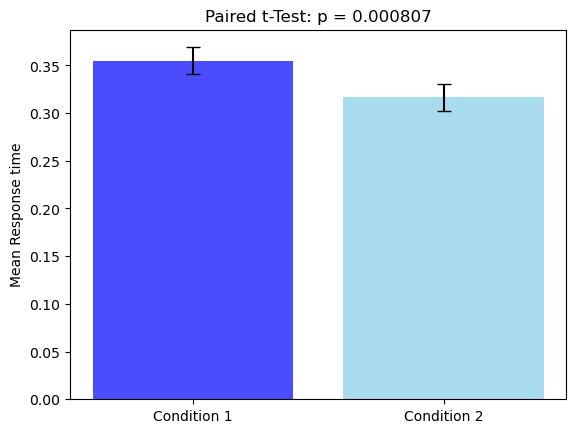

In [46]:
t_plot(avg_rt1, avg_rt2, 'Response time')

T-Statistic: 4.566875565701779, P-Value: 0.0008074980263990667
95% Confidence Interval for Accuracy differences: [-0.057, -0.020]


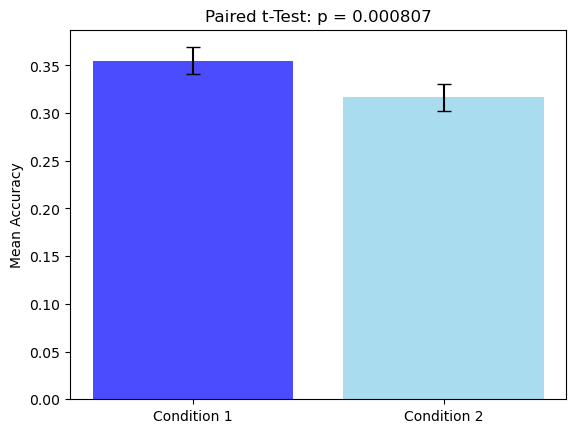

In [47]:
t_plot(avg_rt1, avg_rt2, 'Accuracy')

Part 2: Fitting the models

In [ ]:
def get_parameters(data, condition, idx):
    # Define the DDM model
    m = pyddm.Model(
        drift=pyddm.models.DriftConstant(drift = pyddm.Fittable(minval = -5, maxval=5)),
        noise=pyddm.models.NoiseConstant(noise = pyddm.Fittable(minval = 0.1, maxval=2)),
        bound=pyddm.models.BoundConstant(B = pyddm.Fittable(minval = 0.5, maxval=3)),
        overlay=pyddm.models.OverlayNonDecision(
            nondectime=pyddm.Fittable(minval = 0, maxval = 0.5)
        ),
        IC = pyddm.models.ICPoint(x0 = pyddm.Fittable(minval = 0.01, maxval = 0.49)), 
        T_dur = 4, dt = .001
    )

    # Filter the data
    filtered_data = data[
        (data['subjects'] == idx) &
        (data['flankers'] == condition)
    ]

    # Convert to PyDDM sample
    sample = pyddm.Sample.from_pandas_dataframe(
        filtered_data,
        rt_column_name = "rt",
        choice_column_name = "correct"
    )

    # Fit the model
    pyddm.fit_adjust_model(
        model = m,
        sample = sample,
        lossfunction = pyddm.LossRobustLikelihood,
        verbose = False
    )


    # Extract parameters
    drift =  float(m.parameters()['drift']['drift'])
    #print(drift)
    bound = float(m.parameters()['bound']['B'])
    x0 = float(m.parameters()['IC']['x0']) 
    nondectime = float(m.parameters()['overlay']['nondectime'])

    return (drift, bound, x0, nondectime)


In [25]:
columns = ["Drift", "Boundary", "Starting point", "Non-decision time"]
parameters_condition1 = pd.DataFrame(columns=columns)
parameters_condition2 = pd.DataFrame(columns=columns)

for idx in range(1, n_participants + 1):
    parameters_condition1.loc[idx] = get_parameters(data, 'congruent', idx)
    parameters_condition2.loc[idx] = get_parameters(data, 'incongruent', idx)


Info: Params [1.92024417 1.84504598 1.09117518 0.01538801 0.14975456] gave 48.6507424895339
Info: Params [1.60638685 1.84699589 1.11108395 0.01066079 0.14985625] gave 72.11060762766718
Info: Params [3.60711557 1.64431946 1.04004354 0.01863735 0.06224752] gave -81.05450138154309
Info: Params [2.50991179 1.86704459 1.14455507 0.01015264 0.06209786] gave 22.553595973521226
Info: Params [2.23673933 1.84397003 1.08901821 0.06634527 0.10052788] gave 17.21009607362428
Info: Params [3.2757587  1.98114857 1.20000001 0.01166475 0.09676143] gave -17.408457165679174
Info: Params [3.61921205 1.64458001 0.77112171 0.01333031 0.16114626] gave -145.48795381440556
Info: Params [2.41419416 1.64051821 0.76186328 0.03854677 0.16262518] gave -84.87075026437313
Info: Params [4.71443034 1.57468828 0.98926429 0.01599737 0.17587637] gave -172.65438373690483
Info: Params [0.84829109 1.90901663 1.09602304 0.01098071 0.16389128] gave 82.92861873846975
Info: Params [3.65711466 1.6066801  0.92895835 0.06225548 0.13

In [26]:
parameters_condition1

,Drift,Boundary,Starting point,Non-decision time
1,1.920244,1.091175,0.015388,0.149755
2,3.607116,1.040044,0.018637,0.062248
3,2.236739,1.089018,0.066345,0.100528
4,3.619212,0.771122,0.013330,0.161146
5,4.714430,0.989264,0.015997,0.175876
6,3.657115,0.928958,0.062255,0.136550
7,2.482461,0.913880,0.017707,0.121033
8,3.558818,1.053608,0.044571,0.090727
9,3.505846,0.657317,0.010017,0.084014
10,4.234537,1.342459,0.034543,0.136130


In [27]:
parameters_condition2

,Drift,Boundary,Starting point,Non-decision time
1,1.606387,1.111084,0.010661,0.149856
2,2.509912,1.144555,0.010153,0.062098
3,3.275759,1.200000,0.011665,0.096761
4,2.414194,0.761863,0.038547,0.162625
5,0.848291,1.096023,0.010981,0.163891
6,2.178046,1.142933,0.017941,0.126851
7,2.927713,1.202385,0.074420,0.117287
8,2.131738,1.202640,0.011952,0.092114
9,1.836355,1.009409,0.011623,0.079481
10,2.877108,1.343623,0.092431,0.130361


In [ ]:
def comparison_plot(parameter1, parameter2, name):
    plt.figure(figsize=(8, 6))
    plt.title(f"Optimized {name} by Condition", fontsize=14)
    plt.xlabel("Condition", fontsize=12)
    plt.ylabel(f"{name} Value", fontsize=12)

    # Plot each participant's parameter values
    for idx, (val1, val2) in enumerate(zip(parameter1, parameter2), start=1):
        plt.plot(
            ["Condition 1", "Condition 2"],  
            [val1, val2],
            marker = "o", 
            alpha = 0.7, 
            label = f"Participant {idx}"
        )

    # Customize legend, grid, and layout
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', fontsize = 10, title = "Participants")
    plt.grid(alpha = 0.5)
    plt.tight_layout()
    plt.show()


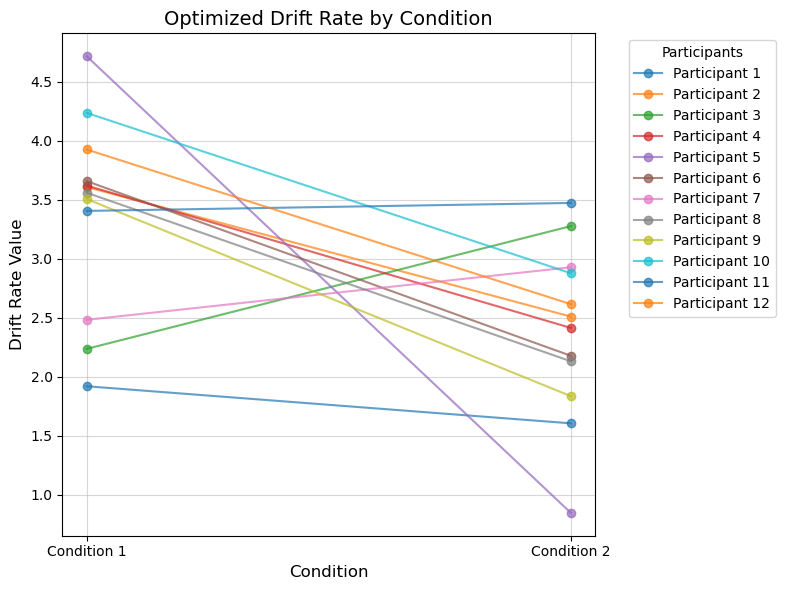

T-Statistic: 2.8098561950949903, P-Value: 0.016972877440117048
95% Confidence Interval for Drift Rate differences: [-1.809, -0.220]


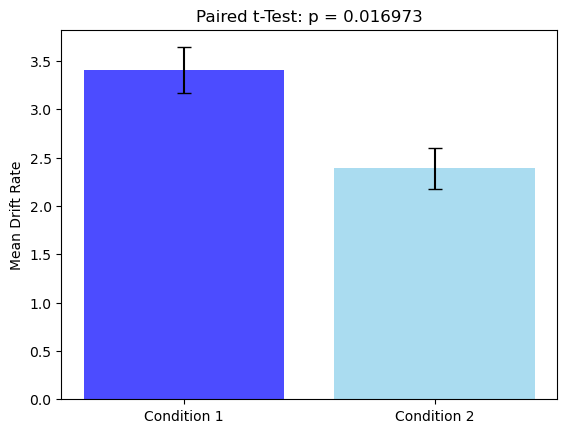

In [52]:
# Generate comparison plot for 'Drift' parameter
comparison_plot(
    parameters_condition1["Drift"],
    parameters_condition2["Drift"],
    "Drift Rate"
)

# Perform paired t-test and plot for 'Drift' parameter
t_plot(
    parameters_condition1["Drift"],
    parameters_condition2["Drift"],
    "Drift Rate"
)


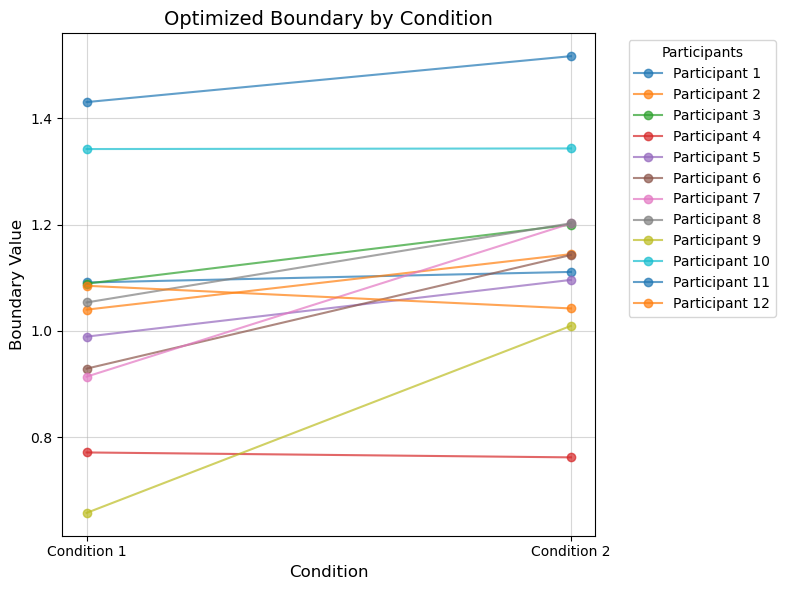

T-Statistic: -3.3006569539256945, P-Value: 0.007069744197226192
95% Confidence Interval for Boundary differences: [0.038, 0.192]


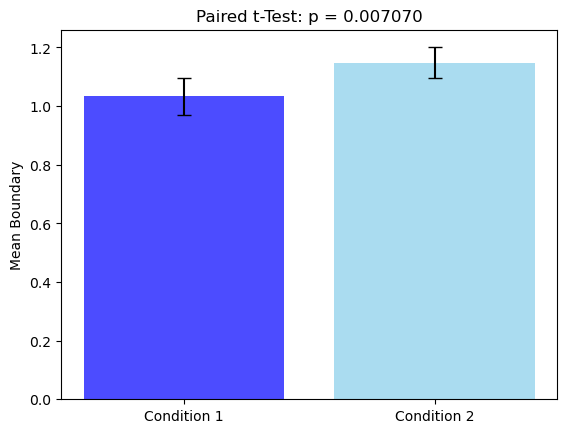

In [53]:
# Generate comparison plot for 'Boundary' parameter
comparison_plot(
    parameters_condition1["Boundary"],
    parameters_condition2["Boundary"],
    "Boundary"
)

# Perform paired t-test and plot for 'Boundary' parameter
t_plot(
    parameters_condition1["Boundary"],
    parameters_condition2["Boundary"],
    "Boundary"
)


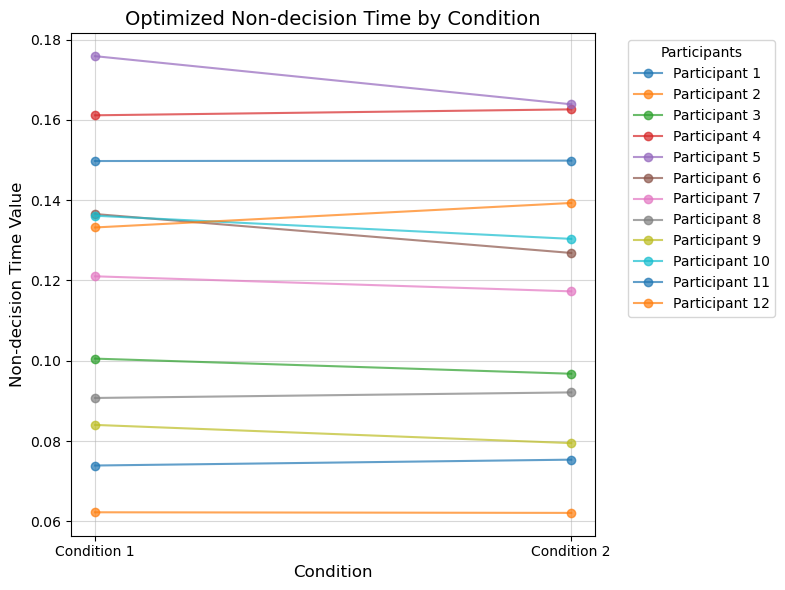

T-Statistic: 1.630031899204389, P-Value: 0.13136887015368204
95% Confidence Interval for Non-decision Time differences: [-0.006, 0.001]


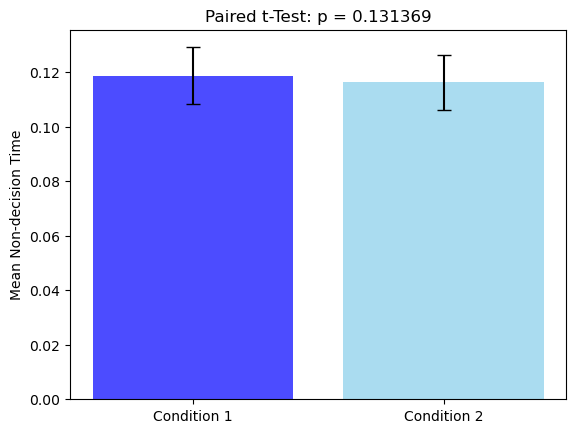

In [54]:
# Generate comparison plot for 'Non-decision time' parameter
comparison_plot(
    parameters_condition1["Non-decision time"],
    parameters_condition2["Non-decision time"],
    "Non-decision Time"
)

# Perform paired t-test and plot for 'Non-decision time' parameter
t_plot(
    parameters_condition1["Non-decision time"],
    parameters_condition2["Non-decision time"],
    "Non-decision Time"
)


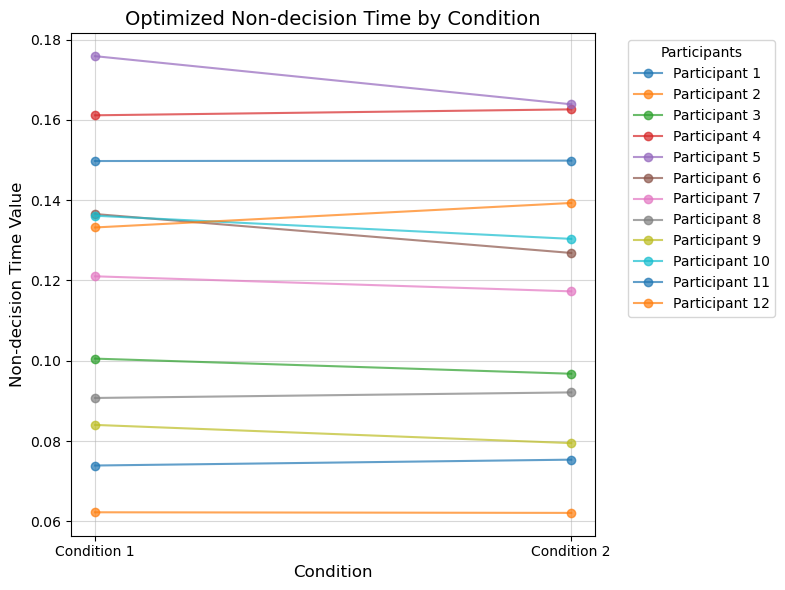

T-Statistic: 1.630031899204389, P-Value: 0.13136887015368204
95% Confidence Interval for Non-decision Time differences: [-0.006, 0.001]


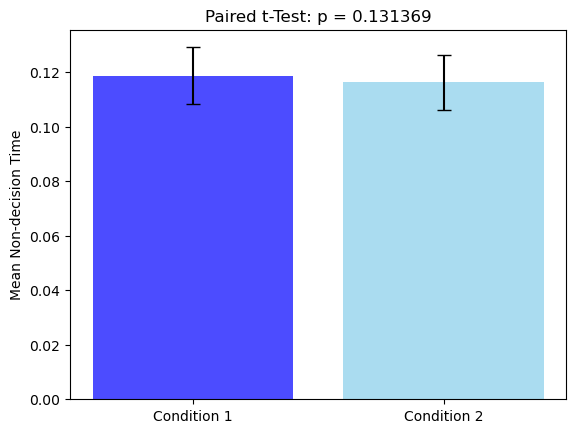

In [ ]:
# Generate comparison plot for 'Non-decision time' parameter
comparison_plot(
    parameters_condition1["Non-decision time"],
    parameters_condition2["Non-decision time"],
    "Non-decision Time"
)

# Perform paired t-test and plot for 'Non-decision time' parameter
t_plot(
    parameters_condition1["Non-decision time"],  
    parameters_condition2["Non-decision time"],
    "Non-decision Time"

)
